In [1]:
data=spark.read.csv('./data/flights.csv',header=True,inferSchema=True)
# from pyspark.sql.functions import monotonically_increasing_irdf.na.drop().show()d 
# data = data.select("*").withColumn("ID", monotonically_increasing_id())

In [2]:
data.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

In [16]:
# data=data.na.drop()
# data.count()

5819079

In [2]:
data1=data.drop('TAXI_OUT','TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME','AIR_SYSTEM_DELAY')
# drop na value
data2=data1.na.drop()
# data.count()

In [55]:
data2.printSchema()

root
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)



In [3]:
#convert departure time to the number of minutes in a day
# from pyspark import SparkContext
# from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
def convert(time):
    min=time%100
    h=int(time/100)
    return h*60+min

    
time_converter=udf(lambda s:convert(s),IntegerType())
data3=data2.select('*',time_converter(data2['SCHEDULED_DEPARTURE'])\
                 .alias('NEW_SCHEDULED_DEPARTURE'))
                 
# data.count()

In [4]:
from pyspark.sql.types import IntegerType
from operator import add
#combine day and month:
months = [31,28,31,30,31,30,31,31,30,31,30,31]
accu=0
accu_months=[0]
for element in months:
    accu +=element
    accu_months.append(accu)
transform = udf(lambda month:accu_months[month-1],IntegerType())

# data=data.select('*',(transform(data['MONTH'])+data['DAY']).alias('NEW_DAY'))
# data.withColumn('NEW_DAY',transform(data['MONTH'])+data['DAY'])

data4=data3.select('*',(transform(data3['MONTH'])+data3['DAY'])\
            .alias('NEW_DAY'))\
#             .drop('MONTH')\
#             .drop('DAY')

# data.count()

In [5]:
data5=data4.drop('MONTH').drop('DAY').drop('SCHEDULED_DEPARTURE')
# data=data.drop('DAY')
# data=data.drop('SCHEDULED_DEPARTURE')
# data.count()

In [63]:
data5.printSchema()
# data5.select('NEW_SCHEDULED_DEPARTURE','NEW_DAY').head(10)
# data5.count()

root
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)
 |-- NEW_SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- NEW_DAY: integer (nullable = true)



5714008

In [ ]:
from pyspark.sql.functions import col, size,length
data6=data5.filter(length(data5['DESTINATION_AIRPORT']) <= 3)
data7=data6.filter(length(data6['ORIGIN_AIRPORT']) <= 3
data7.count()

In [49]:
# test_data=data.sample(False, 0.1,0)
# train_data=data.select('*').filter('ID'!=test_data['ID'])

train_data,test_data=data7.randomSplit((0.8,0.2), 0)

In [51]:
# test_data.groupBy().avg("DEPARTURE_DELAY").show()
print(test_data.count())
print(train_data.count())
# test_data.sum('DEPARTURE_DELAY').show()

1045579
4185551


In [27]:
train_data.printSchema()

root
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)
 |-- NEW_SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- NEW_DAY: integer (nullable = true)



In [70]:
test_data.groupBy().avg("DEPARTURE_DELAY").show()
train_data.groupBy().avg("DEPARTURE_DELAY").show()



+--------------------+
|avg(DEPARTURE_DELAY)|
+--------------------+
|   9.275051412092544|
+--------------------+

+--------------------+
|avg(DEPARTURE_DELAY)|
+--------------------+
|   9.299786493931121|
+--------------------+



In [50]:
test_data.write.csv('./data/test_flight.csv',header=True,mode='overwrite')
train_data.write.csv('./data/train_flight.csv',header=True,mode='overwrite')


In [61]:
data7.write.csv('./data/whole_flight_data.csv',header=True,mode='overwrite')

## Start to analyze 

In [52]:
data=spark.read.csv('./data/train_flight.csv',header=True,inferSchema=True)
data.printSchema()

root
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)
 |-- NEW_SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- NEW_DAY: integer (nullable = true)



In [30]:
import matplotlib as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt







### Analysis: departure time and departure delay

In [ ]:
depTime_delay=data.select('schedule_departure','DEPARTURE_DELAY')

depTime_delay_sample=depTime_delay.sample(False, 0.1,0).toPandas()

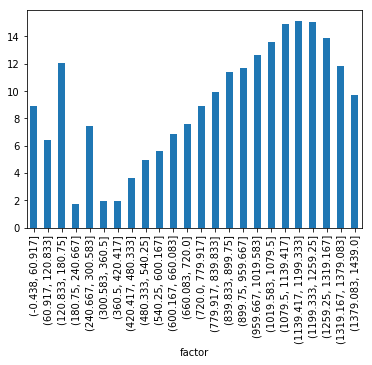

In [31]:
# factor = pd.cut(depTime_delay_sample['schedule_departure'], 24)
# pd.value_counts(factor)
depTime_delay_sample['factor']=pd.cut(depTime_delay_sample['schedule_departure'], 24)
depTime_delay_sample.groupby(['factor'])['DEPARTURE_DELAY'].mean().plot.bar()
plt.show()

### Analysis: day in week and departure delay

In [32]:
week_delay=data.select('DAY_OF_WEEK','DEPARTURE_DELAY')

week_delay_sample=week_delay.sample(False, 0.1,0).toPandas()


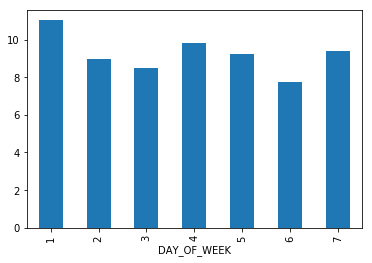

In [41]:
bins = [0, 5, 7]
# week_delay_sample['isWeekend']=pd.cut(week_delay_sample['DAY_OF_WEEK'], bins,labels=['N','Y'])
week_delay_sample.groupby(['DAY_OF_WEEK'])['DEPARTURE_DELAY'].mean().plot.bar()
plt.show()

### Analysis: day in year and departure delay

In [44]:
date_delay=data.select('NEW_DAY','DEPARTURE_DELAY')
date_delay_sample=date_delay.sample(False, 0.1,0).toPandas()

In [60]:
date_avgDelay=date_delay_sample.groupby(['NEW_DAY'])['DEPARTURE_DELAY'].mean().reset_index(name='mean')
date_avgDelay.sort_values(by=['mean'],ascending=False).head(20)

,NEW_DAY,mean
362,363,32.236780
3,4,32.125687
360,361,31.909857
363,364,29.159271
361,362,29.083407
2,3,25.394889
5,6,25.342954
137,138,25.224313
59,60,24.326779
357,358,24.091083


### Analysis: distance and departure delay


In [22]:
distance_delay=data.select('DISTANCE','DEPARTURE_DELAY')
distance_delay_sample=distance_delay.sample(False, 0.1,0).toPandas()

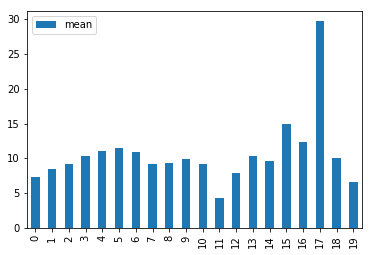

,DISTANCE_INTERVAL,mean
17,"(4240.2, 4487.8]",29.735849
15,"(3745.0, 3992.6]",14.991525
16,"(3992.6, 4240.2]",12.307692
5,"(1269.0, 1516.6]",11.526258
4,"(1021.4, 1269.0]",10.999720
6,"(1516.6, 1764.2]",10.941601
3,"(773.8, 1021.4]",10.406810
13,"(3249.8, 3497.4]",10.391892
18,"(4487.8, 4735.4]",10.039216
9,"(2259.4, 2507.0]",9.942630


In [77]:
distance_delay_sample['DISTANCE_INTERVAL']=pd.cut(distance_delay_sample['DISTANCE'], 20)
distance_avgDelay=distance_delay_sample.groupby(['DISTANCE_INTERVAL'])['DEPARTURE_DELAY'].mean().reset_index(name='mean')
distance_avgDelay.plot.bar()
plt.show()

distance_avgDelay.sort_values(by=['mean'],ascending=False).head(20)


### Analysis: origin airport and departure delay

In [54]:
airport_delay=data.select('ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY')
airport_delay_sample=airport_delay.sample(False, 0.1,0).toPandas()

In [55]:
airport_avgDelay=airport_delay_sample.groupby(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'])['DEPARTURE_DELAY'].mean().reset_index(name='mean')


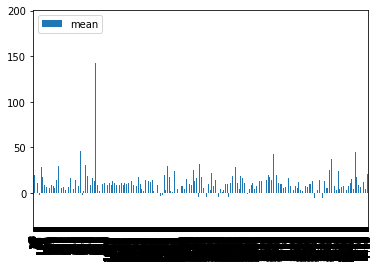

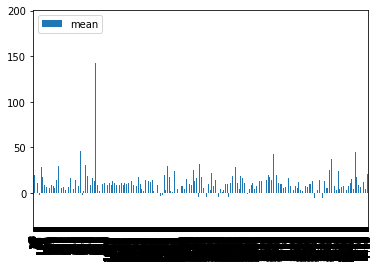

In [57]:
airport_avgDelay.plot.bar()
# plt.savefig('./figures/airport_delay.png',dpi=200)
plt.show()
# airport_avgDelay.count()

In [59]:
data.groupby('DESTINATION_AIRPORT').count().sort('count').show()
data.groupby('ORIGIN_AIRPORT').count().sort('count').show()

+-------------------+-----+
|DESTINATION_AIRPORT|count|
+-------------------+-----+
|                ITH|   28|
|                AKN|   49|
|                STC|   54|
|                GST|   55|
|                HYA|   62|
|                DLG|   64|
|                ILG|   70|
|                ADK|   72|
|                PPG|   88|
|                MMH|  113|
|                UST|  127|
|                CEC|  140|
|                VEL|  158|
|                MVY|  161|
|                CNY|  162|
|                WYS|  163|
|                BGM|  203|
|                PUB|  212|
|                OTH|  214|
|                PBG|  231|
+-------------------+-----+
only showing top 20 rows

+--------------+-----+
|ORIGIN_AIRPORT|count|
+--------------+-----+
|           ITH|   26|
|           AKN|   49|
|           DLG|   62|
|           STC|   64|
|           GST|   65|
|           HYA|   69|
|           ILG|   71|
|           ADK|   75|
|           PPG|   79|
|           UST|  114|
|  

### Analysis: airline and departure delay

In [19]:
airline_delay=data.select('AIRLINE','DEPARTURE_DELAY')
airline_delay_sample=airline_delay.sample(False, 0.1,0).toPandas()

In [21]:
airline_avgDelay=airline_delay_sample.groupby('AIRLINE')['DEPARTURE_DELAY'].mean().reset_index(name='mean')

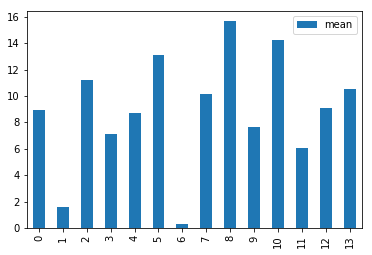

In [22]:
airline_avgDelay.plot.bar()
# plt.savefig('./figures/airline_delay.png',dpi=200)
plt.show()

In [23]:
airline_airport_delay=data.select('AIRLINE','ORIGIN_AIRPORT','DEPARTURE_DELAY')
airline_airport_delay_sample=airline_airport_delay.sample(False, 0.1,0).toPandas()
airline_airport_avgDelay=airline_airport_delay_sample.groupby(['ORIGIN_AIRPORT','AIRLINE'])['DEPARTURE_DELAY'].mean().reset_index(name='mean')

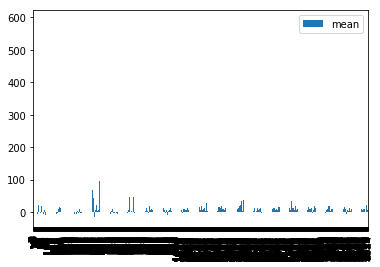

In [24]:
airline_airport_avgDelay.plot.bar()
# plt.savefig('./figures/airline_delay.png',dpi=200)
plt.show()

### Analysis: airport classification

In [62]:
whole_data=spark.read.csv('./data/whole_flight_data.csv',header=True,inferSchema=True)

In [142]:
import pyspark.sql.functions as func
airport_analysis=whole_data.select('ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY')
airport_analysis_pd1=airport_analysis.groupby('ORIGIN_AIRPORT')\
                .agg(func.countDistinct('DESTINATION_AIRPORT'),func.avg('DEPARTURE_DELAY'))\
                .toPandas()
#                 .show()
# airport_analysis_pd.plot.scatter('count(DESTINATION_AIRPORT)','avg(DEPARTURE_DELAY)')

In [130]:
airport_analysis_pd2=airport_analysis.groupby('DESTINATION_AIRPORT')\
                .agg(func.count('ORIGIN_AIRPORT'),func.avg('DEPARTURE_DELAY'))\
                .toPandas()

In [143]:
airport_analysis_pd1.head(10)
# airport_analysis_pd2.head(10)

,ORIGIN_AIRPORT,count(DISTINCT DESTINATION_AIRPORT),avg(DEPARTURE_DELAY)
0,BGM,1,10.610039
1,DLG,1,0.558442
2,PSE,2,2.734417
3,INL,3,4.314748
4,MSY,38,8.651442
5,PPG,1,15.179245
6,GEG,10,4.934428
7,SNA,22,6.511605
8,BUR,11,5.978842
9,GRB,4,4.483686


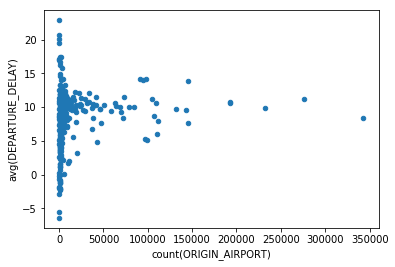

In [100]:
airport_analysis_pd2.plot.scatter('count(ORIGIN_AIRPORT)','avg(DEPARTURE_DELAY)')
plt.show()

In [144]:
airport_analysis_pd1[['count(DISTINCT DESTINATION_AIRPORT)','avg(DEPARTURE_DELAY)']].corr()

,count(DISTINCT DESTINATION_AIRPORT),avg(DEPARTURE_DELAY)
count(DISTINCT DESTINATION_AIRPORT),1.000000,0.245193
avg(DEPARTURE_DELAY),0.245193,1.000000


In [129]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
dataset = [[Vectors.dense([1, 0, 0, -2])],
            [Vectors.dense([4, 5, 0, 3])],
            [Vectors.dense([6, 7, 0, 8])],
           [Vectors.dense([9, 0, 0, 1])]]
dataset = spark.createDataFrame(dataset, ['features'])
pearsonCorr = Correlation.corr(dataset, 'features', 'pearson').collect()[0][0]
print(str(pearsonCorr).replace('nan', 'NaN'))

spearmanCorr = Correlation.corr(dataset, 'features', method='spearman').collect()[0][0]
print(str(spearmanCorr).replace('nan', 'NaN'))

DenseMatrix([[ 1.        ,  0.05564149,         NaN,  0.40047142],
             [ 0.05564149,  1.        ,         NaN,  0.91359586],
             [        NaN,         NaN,  1.        ,         NaN],
             [ 0.40047142,  0.91359586,         NaN,  1.        ]])
DenseMatrix([[ 1.        ,  0.10540926,         NaN,  0.4       ],
             [ 0.10540926,  1.        ,         NaN,  0.9486833 ],
             [        NaN,         NaN,  1.        ,         NaN],
             [ 0.4       ,  0.9486833 ,         NaN,  1.        ]])
